<a href="https://colab.research.google.com/github/Nisha40108/ParkNaviGo/blob/main/CNN_model_for_occupancy_KSU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
!pip install tensorflow==2.12

  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)


In [18]:
import os
import pandas as pd
import numpy

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

In [2]:
# Define the path to your images folder and labels CSV file
images_folder = '/content/drive/MyDrive/nisha/train_data/train/Image'
labels_csv = '/content/drive/MyDrive/nisha/train_data/train/labels.csv'  # Replace with the actual path

# Initialize variables to count the number of empty and occupied images
empty_count = 0
occupied_count = 0

# Initialize lists to store image filenames and labels
image_files = []
labels = []

# Iterate over subfolders in the main folder
for sub_folder in os.listdir(images_folder):
    sub_folder_path = os.path.join(images_folder, sub_folder)

    # Check if it's a directory
    if os.path.isdir(sub_folder_path):
        # Get the list of files in the subfolder
        files = os.listdir(sub_folder_path)

        # Update counts based on the number of files
        if "empty" in sub_folder:
            empty_count += len(files)
            label = "empty"
        elif "occupied" in sub_folder:
            occupied_count += len(files)
            label = "occupied"
        else:
            label = None  # or assign a different label for other cases
        image_files.extend([os.path.join(sub_folder_path, file) for file in files])
        labels.extend([label] * len(files))



In [3]:
# Verify counts
print("Number of empty images:", empty_count)
print("Number of occupied images:", occupied_count)

Number of empty images: 17
Number of occupied images: 8


In [4]:
# Create a DataFrame
data = {'Image': image_files, 'Label': labels}
Empty_Occupied_df = pd.DataFrame(data)

# Print the DataFrame for verification
print(Empty_Occupied_df.head(25))

# Save the DataFrame to the CSV file
Empty_Occupied_df.to_csv(labels_csv, index=False)


                                                Image     Label
0   /content/drive/MyDrive/nisha/train_data/train/...     empty
1   /content/drive/MyDrive/nisha/train_data/train/...     empty
2   /content/drive/MyDrive/nisha/train_data/train/...     empty
3   /content/drive/MyDrive/nisha/train_data/train/...     empty
4   /content/drive/MyDrive/nisha/train_data/train/...     empty
5   /content/drive/MyDrive/nisha/train_data/train/...     empty
6   /content/drive/MyDrive/nisha/train_data/train/...     empty
7   /content/drive/MyDrive/nisha/train_data/train/...     empty
8   /content/drive/MyDrive/nisha/train_data/train/...     empty
9   /content/drive/MyDrive/nisha/train_data/train/...     empty
10  /content/drive/MyDrive/nisha/train_data/train/...     empty
11  /content/drive/MyDrive/nisha/train_data/train/...     empty
12  /content/drive/MyDrive/nisha/train_data/train/...     empty
13  /content/drive/MyDrive/nisha/train_data/train/...     empty
14  /content/drive/MyDrive/nisha/train_d

In [6]:
from sklearn.model_selection import train_test_split
# Split the data into training (70%), validation (15%), and test (15%) sets
train_df, temp_df = train_test_split(Empty_Occupied_df, test_size=0.3, random_state=48)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=48)

# Print the number of samples in each set for verification
print("Number of samples in training set:", len(train_df))
print("Number of samples in validation set:", len(validation_df))
print("Number of samples in test set:", len(test_df))

Number of samples in training set: 17
Number of samples in validation set: 4
Number of samples in test set: 4


In [7]:
# Constants
img_width, img_height = 224, 224
batch_size = 32
epochs = 10
num_classes = 2  # Number of classes (empty and occupied)

# Data Generators
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode = "nearest",
                                   width_shift_range = 0.1,
                                   height_shift_range=0.1,
                                   rotation_range=5)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode = "nearest",
                                   width_shift_range = 0.1,
                                   height_shift_range=0.1,
                                   rotation_range=5)

Validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode = "nearest",
                                   width_shift_range = 0.1,
                                   height_shift_range=0.1,
                                   rotation_range=5)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=images_folder,
    x_col="Image",
    y_col="Label",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",  # Change to 'binary' for binary classification
    target_size=(img_width, img_height)
)

validation_generator = Validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=images_folder,
    x_col="Image",
    y_col="Label",
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(img_width, img_height)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=images_folder,
    x_col="Image",
    y_col="Label",
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(img_width, img_height)
)

Found 17 validated image filenames belonging to 2 classes.
Found 4 validated image filenames belonging to 1 classes.
Found 4 validated image filenames belonging to 2 classes.


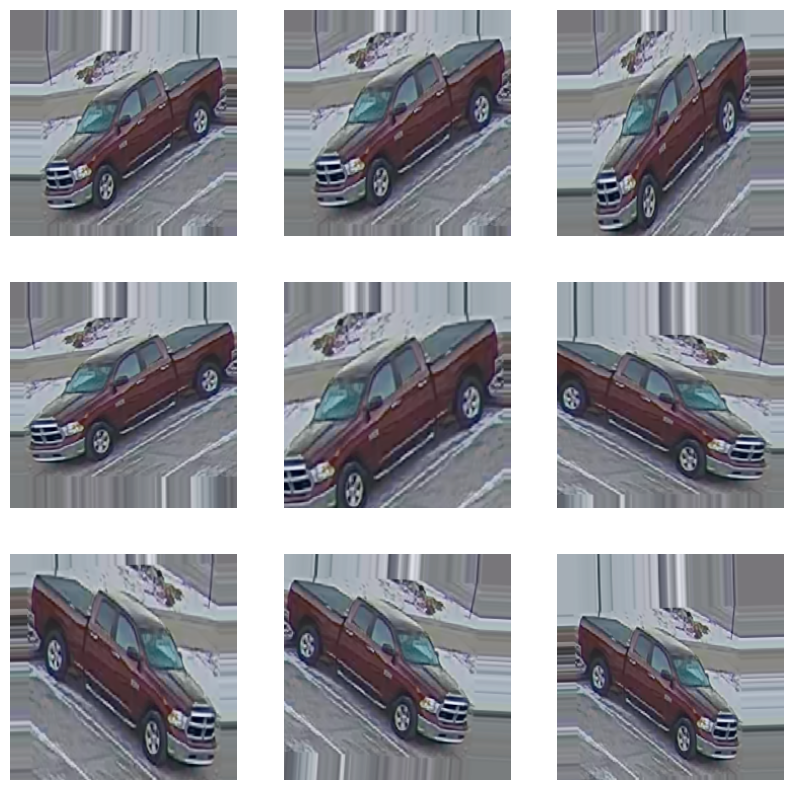

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_generator:
    for i in range(9):
        # Select a single image from the batch
        img = images[0]
        # Apply random transformation to the selected image
        augmented_image = train_datagen.random_transform(img)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        plt.axis("off")
    break  # Break the loop after the first batch
plt.show()

In [12]:
data_batch, labels_batch = train_generator.next()

# Print the shapes
print("Data Batch Shape:", data_batch.shape)
print("Labels Batch Shape:", labels_batch.shape)

Data Batch Shape: (17, 224, 224, 3)
Labels Batch Shape: (17, 2)


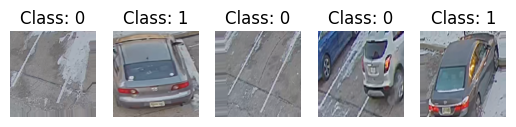

In [13]:
# Number of images to plot
num_images_to_plot = 5

# Plot the images
for i in range(num_images_to_plot):
    # Get the i-th image and label
    image = data_batch[i]
    label = labels_batch[i]

    # Convert one-hot encoded label to class index
    class_index = label.argmax()

    # Plot the image
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {class_index}")
    plt.axis("off")

plt.show()

#**Creating** Simple model from scratch

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                      

In [40]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
# Save the model according to the conditions

callbacks = ModelCheckpoint("car1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

In [42]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
save_directory = '/content/drive/MyDrive/nisha'
checkpoint_filepath = os.path.join(save_directory, 'car1.h5')

In [23]:
for batch in train_generator:
    break  # Break after the first batch to print information
print("Number of batches:", len(train_generator))
print("Number of samples in the first batch:", batch[0].shape)

# Set steps_per_epoch based on the number of batches in an epoch
steps_per_epoch = len(train_generator)

Number of batches: 1
Number of samples in the first batch: (17, 224, 224, 3)


In [24]:
for batch in validation_generator:
    break  # Break after the first batch to print information
print("Number of batches:", len(train_generator))
print("Number of samples in the first batch:", batch[0].shape)

# Set steps_per_epoch based on the number of batches in an epoch
steps_per_epoch = len(train_generator)

Number of batches: 1
Number of samples in the first batch: (4, 224, 224, 3)


In [50]:
Model_1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[callbacks, early],
    batch_size=1  # Add this line
)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 1: val_accuracy did not improve from 1.00000
1/1 [==============================] - 3s 3s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 2: val_accuracy did not improve from 1.00000
1/1 [==============================] - 2s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 1.00000
1/1 [==============================] - 4s 4s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 4: val_accuracy did not improve from 1.00000
1/1 [==============================] - 4s 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


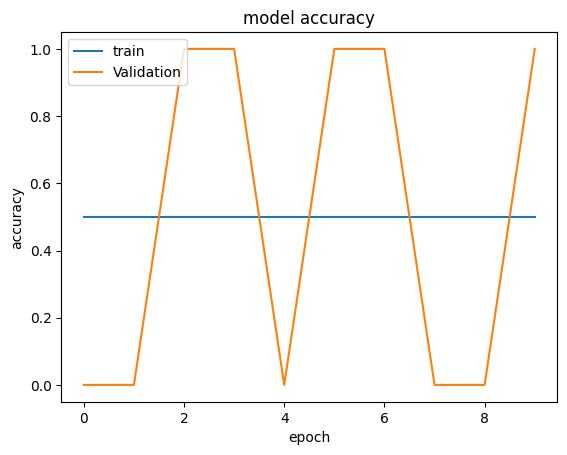

In [51]:
import matplotlib.pyplot as plt
print(Model_1.history.keys())
plt.plot(Model_1.history['accuracy'])
plt.plot(Model_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

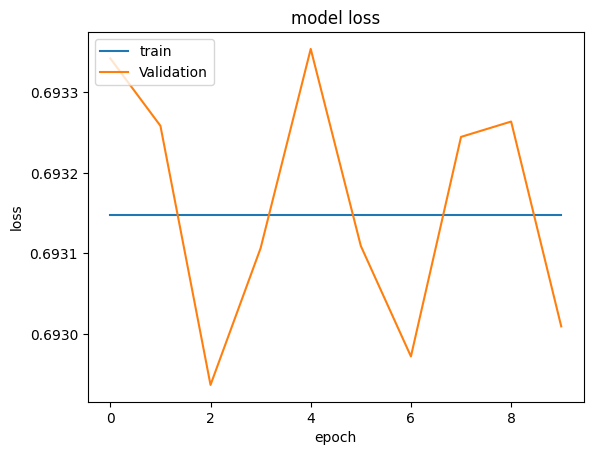

In [53]:
plt.plot(Model_1.history['loss'])
plt.plot(Model_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [54]:
test_model = keras.models.load_model("car1.h5")
Model1_Results = test_model.evaluate(test_generator)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

1/1 [==============================] - 1s 632ms/step - loss: 0.6931 - accuracy: 0.5000
Loss: 0.693
Accuracy: 0.500
